# Preliminary analysis of differentially abundant metabolites (DAMs)

This notebook identifies DAMs in a dataset and performs a preliminary analysis of their accordance across imputation methods with the non-imputed control data.

In [2]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import re
import ast
from tqdm import tqdm
import sklearn
from joblib import Parallel, delayed

# Matplotlib command for Jupyter notebooks only
%matplotlib inline
plt.style.use('tableau-colorblind10')

In [ ]:
# importing custom functions for imputation and evaluation
import sys

sys.path.append("/home/mklein/sc_imputation_denoising")
import sc_imputation_denoising as scid

from sc_imputation_denoising.imputation.constants import const

from sc_imputation_denoising.evaluation.evaluation_workflow import (
    evaluation_workflow,
)

In [4]:
path = "/g/alexandr/Marius/imputation_evaluation"
pickle_path = "/scratch/klein/temp/"
# list all directories in the path
dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
dirs.sort()
dirs

['Lx_Glioblastoma_c0.05_i0.05_fdr1_summary',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl1',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl2',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl3',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl4',
 'Lx_Glioblastoma_cond6_mcar_c0.05_i0.05_fdr1_repl5',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl1',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl2',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl3',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4',
 'Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl5',
 'Lx_HepaRG_c0.2_i0.2_fdr1_summary',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl1',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl2',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl3',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl4',
 'Lx_HepaRG_cond4_mcar_c0.2_i0.2_fdr1_repl5',
 'Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl1',
 'Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl2',
 'Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl3',
 'Lx_HepaR

In [5]:
datasets = dict(
    Mx_Seahorse=dict(c=0.1, i=0.2, repl=1),
    Lx_Pancreatic_Cancer=dict(c=0.2, i=0.05, repl=1),
    Lx_Glioblastoma=dict(c=0.05, i=0.05, repl=4),
    Lx_HepaRG=dict(c=0.2, i=0.2, repl=5),
)

fdr = 1
sum_path = os.path.join(path, "summary")
if not os.path.exists(sum_path):
    os.makedirs(sum_path)

for dset, params in datasets.items():
    print(dset)
    datasets[dset]["summary_folder"] = (
        dset
        + "_c"
        + str(params["c"])
        + "_i"
        + str(params["i"])
        + "_fdr"
        + str(fdr)
        + "_summary"
    )
    prefix = datasets[dset]["prefix"] = (
        "^"
        + dset
        + "_.*"
        + "_c"
        + str(params["c"])
        + "_i"
        + str(params["i"])
        + "_fdr"
        + str(fdr)
    )
    if "repl" in params:
        prefix += "_repl" + str(params["repl"])
    folders = [d for d in dirs if re.compile(prefix).match(d)]

    datasets[dset]["folders"] = folders

    replicate_list = []
    found_data = False
    while not found_data:
        # for i in range(0, len(folders)):
        repl_folder = folders.pop()
        print(repl_folder)
        try:
            load_df = pd.read_csv(f"{path}/{repl_folder}/evaluation.csv")
            adata_path = f"{path}/{repl_folder}/adata_baseline.h5ad"
            sp_adata_path = f"{path}/{repl_folder}/adata_sparse.h5ad"
            if not os.path.exists(adata_path) or not os.path.exists(sp_adata_path):
                wflow = evaluation_workflow.get_from_pickle(
                    f"{pickle_path}/evaluation_pickle_{repl_folder}_{repl_folder[-1:]}.pkl"
                )

                if not os.path.exists(adata_path):
                    adata = wflow.dataset_dict[wflow.baseline_key].copy()
                    adata.write(adata_path)
                if not os.path.exists(sp_adata_path):
                    dropout_rate = list(wflow.dataset_dict.keys())[-1]
                    print(dropout_rate)
                    adata_d = wflow.dataset_dict[wflow.baseline_key].copy()
                    adata = wflow.dataset_dict[dropout_rate].copy()
                    adata.layers["baseline"] = adata_d.layers["ctrl"]
                    adata.uns["dropout_rate"] = dropout_rate
                    adata.write(sp_adata_path)
                del wflow
            replicate_list.append(
                dict(
                    dataset=dset,
                    replicate=repl_folder,
                    adata_path=adata_path,
                    sp_adata_path=sp_adata_path,
                    min_ions=params["i"],
                    min_cells=params["c"],
                    save_to=f"{path}/{repl_folder}",
                )
            )
            found_data = True

        except Exception as e:
            print(e)

    if not found_data:
        print(f"no data found for dataset {dset}")
        continue

    concat_df = pd.DataFrame(replicate_list)

    datasets[dset]["data"] = concat_df

Mx_Seahorse
Mx_Seahorse_cond4_mnar_c0.1_i0.2_fdr1_repl1
Lx_Pancreatic_Cancer
Lx_Pancreatic_Cancer_cond4_mnar_c0.2_i0.05_fdr1_repl1
Lx_Glioblastoma
Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4
Lx_HepaRG
Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl5


In [6]:
dataset_df = pd.concat(
    [datasets[set]["data"] for set in datasets.keys()], ignore_index=True
)
dataset_df["max_fdr"] = 1
dataset_df

,dataset,replicate,adata_path,sp_adata_path,min_ions,min_cells,save_to,max_fdr
0,Mx_Seahorse,Mx_Seahorse_cond4_mnar_c0.1_i0.2_fdr1_repl1,/g/alexandr/Marius/imputation_evaluation/Mx_Se...,/g/alexandr/Marius/imputation_evaluation/Mx_Se...,0.20,0.10,/g/alexandr/Marius/imputation_evaluation/Mx_Se...,1
1,Lx_Pancreatic_Cancer,Lx_Pancreatic_Cancer_cond4_mnar_c0.2_i0.05_fdr...,/g/alexandr/Marius/imputation_evaluation/Lx_Pa...,/g/alexandr/Marius/imputation_evaluation/Lx_Pa...,0.05,0.20,/g/alexandr/Marius/imputation_evaluation/Lx_Pa...,1
2,Lx_Glioblastoma,Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4,/g/alexandr/Marius/imputation_evaluation/Lx_Gl...,/g/alexandr/Marius/imputation_evaluation/Lx_Gl...,0.05,0.05,/g/alexandr/Marius/imputation_evaluation/Lx_Gl...,1
3,Lx_HepaRG,Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl5,/g/alexandr/Marius/imputation_evaluation/Lx_He...,/g/alexandr/Marius/imputation_evaluation/Lx_He...,0.20,0.20,/g/alexandr/Marius/imputation_evaluation/Lx_He...,1


In [7]:
i = 0
sparse = True

# size of clustermap plots
size = 4

if sparse:
    adata = sc.read_h5ad(dataset_df.iloc[i]["sp_adata_path"])
else:
    adata = sc.read_h5ad(dataset_df.iloc[i]["adata_path"])
adata.uns["log1p"]["base"] = 10
write_path = dataset_df.iloc[i]["save_to"]
write_path = "/home/mklein/Dropouts/figures"
dataset = dataset_df.iloc[i]["dataset"]
dataset_disp = " ".join(dataset.split("_")[1:])
print(dataset_disp)
cond_order_dict = dict(
    Mx_Seahorse=["NStim", "Stim", "2DG", "Oligo"],
    Lx_Glioblastoma=[
        "Naive_WT",
        "TMD_sM",
        "TMD_dM",
        "TMD_tM",
        "TMD_CD95_WT",
        "TMD_CD95_KO",
    ],
    Lx_Pancreatic_Cancer=["HPAF", "HPAC", "PSN1", "MiaPaca2"],
    Lx_HepaRG=["U", "F", "FI", "FIT"],
)

cond_order = cond_order_dict[dataset]
exclude_imps = const.EXCLUDE_IMPUTATION + ["fancy_iterative"]
adata.var.index.name = "index"
dataset_set = dataset
if sparse:
    dataset = dataset + "_sparse"
adata.layers

Seahorse


Layers with keys: ALRA, MAGIC_t1, MAGIC_t2, MAGIC_t3, MAGIC_t5, baseline, ctrl, ctrl_mean, ctrl_median, ctrl_random, dca_nb, dca_nb-conddisp, dca_zinb, dca_zinb-conddisp, fancy_iterative, fancy_itersvd, fancy_multi, fancy_soft, fancy_softbi, knn_1, knn_3, knn_5

In [8]:
all_ions = adata.var_names
ion_df_list = []
for layer in list(set(adata.layers.keys()).difference(exclude_imps)):
    df = pd.DataFrame(
        adata[:, all_ions].layers[layer],
        columns=pd.MultiIndex.from_tuples([(layer, ion) for ion in all_ions]),
        index=adata.obs_names,
    )
    ion_df_list.append(df)

ion_df = pd.concat(ion_df_list, axis=1)
ion_df = pd.merge(
    ion_df, adata.obs[["condition", "sample"]], left_index=True, right_index=True
).set_index(["condition", "sample"], append=True)
ion_df.columns = pd.MultiIndex.from_tuples(ion_df.columns)
long_ion_df = ion_df.reset_index().melt(
    id_vars=["cell_id", "condition", "sample"], var_name=["layer", "ion"]
)
long_ion_df["imputation"] = long_ion_df["layer"]

/tmp/ipykernel_75/1222607309.py:12: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  ion_df = pd.merge(


In [166]:
corr_df = long_ion_df.pivot(
    index=["cell_id", "condition", "sample", "ion"],
    columns=["imputation"],
    values="value",
).corr()

In [167]:
min_corr = corr_df.min().min()
min_corr

0.5422574108443861

In [ ]:
compare_layers_df = long_ion_df.pivot(
    index=["cell_id", "condition", "sample", "ion"],
    columns=["imputation"],
    values="value",
)

In [79]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = np.zeros(
    (len(compare_layers_df.columns), len(compare_layers_df.columns))
)
for k, column in enumerate(compare_layers_df.columns):
    for j, column2 in list(enumerate(compare_layers_df.columns))[k:]:
        if column != column2:
            cosine = cosine_similarity(
                compare_layers_df[column].values.reshape(1, -1),
                compare_layers_df[column2].values.reshape(1, -1),
            )
            cosine_matrix[k, j] = cosine_matrix[j, k] = cosine[0, 0]
        else:
            cosine_matrix[k, j] = 1

In [171]:
min_cos = cosine_matrix.min().min()
min_cos

bar_min = np.min([min_cos, min_corr])

In [ ]:
fig = sns.clustermap(corr_df, figsize=(4, 4), vmin=bar_min)
fig.fig.suptitle(
    f"Correlation between imputation \nmethods on {dataset_disp} dataset", size=10
)
fig.fig.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/{dataset}_correlation_heatmap_imputations.pdf"
)
fig.fig.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/{dataset}_correlation_heatmap_imputations.png"
)

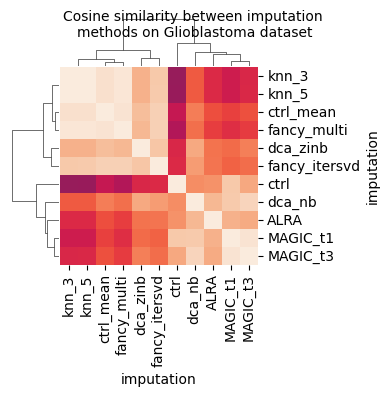

In [82]:
fig = sns.clustermap(
    pd.DataFrame(
        cosine_matrix,
        index=compare_layers_df.columns,
        columns=compare_layers_df.columns,
    ),
    figsize=(4, 4),
    vmin=bar_min,
    cbar_pos=None,
)
fig.fig.suptitle(
    f"Cosine similarity between imputation \nmethods on {dataset_disp} dataset", size=10
)
fig.fig.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/{dataset}_cosine_heatmap_imputations.pdf"
)
fig.fig.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/{dataset}_cosine_heatmap_imputations.png"
)

In [24]:
i = 1
sparse = True

# size of clustermap plots
size = 4

if sparse:
    adata = sc.read_h5ad(dataset_df.iloc[i]["sp_adata_path"])
else:
    adata = sc.read_h5ad(dataset_df.iloc[i]["adata_path"])
adata.uns["log1p"]["base"] = 10
write_path = dataset_df.iloc[i]["save_to"]
write_path = "/home/mklein/Dropouts/figures"
dataset = dataset_df.iloc[i]["dataset"]
dataset_disp = " ".join(dataset.split("_")[1:])
print(dataset_disp)

cond_order = cond_order_dict[dataset]
# exclude_imps = ['dca_nb-conddisp', 'dca_zinb-conddisp', 'fancy_softbi', 'bbmagic_1', 'bbmagic_2', 'bbmagic_3', 'bbmagic_5']
exclude_imps = const.EXCLUDE_IMPUTATION + ["fancy_iterative"]
adata.var.index.name = "index"
if sparse:
    dataset = dataset + "_sparse"
adata.layers

Pancreatic Cancer


Layers with keys: ALRA, MAGIC_t1, MAGIC_t2, MAGIC_t3, MAGIC_t5, baseline, bbmagic_1, bbmagic_2, bbmagic_3, bbmagic_5, ctrl, ctrl_mean, ctrl_median, ctrl_random, dca_nb, dca_nb-conddisp, dca_zinb, dca_zinb-conddisp, fancy_iterative, fancy_itersvd, fancy_multi, fancy_soft, fancy_softbi, knn_1, knn_3, knn_5

In [29]:
set_list = []
for layer in adata.layers.keys():
    adata_imp = adata
    sc.tl.rank_genes_groups(
        adata_imp,
        use_raw=False,
        groupby="condition",
        method="wilcoxon",
        key_added=f"wilcoxon_{layer}",
        layer=layer,
    )
    # sc.pl.rank_genes_groups(adata_magic, n_genes=25, sharey=False, key = "wilcoxon")
    for condition in adata_imp.obs["condition"].unique():
        df = sc.get.rank_genes_groups_df(
            adata_imp,
            group=condition,
            key=f"wilcoxon_{layer}",
            pval_cutoff=0.05,
            log2fc_min=1,
        )  # [['names']]
        df["imputation"] = layer
        df["condition"] = condition
        df["direction"] = "up"
        df["cond"] = condition + " up"
        set_list.append(df.sort_values(by="pvals", ascending=True))

        df = sc.get.rank_genes_groups_df(
            adata_imp,
            group=condition,
            key=f"wilcoxon_{layer}",
            pval_cutoff=0.05,
            log2fc_max=-1,
        )  # [['names']]
        df["imputation"] = layer
        df["condition"] = condition
        df["direction"] = "down"
        df["cond"] = condition + " down"
        set_list.append(df.sort_values(by="pvals", ascending=True))

full_set_df = pd.concat(set_list, ignore_index=True)
full_set_df["group"] = list(
    full_set_df["imputation"].apply(lambda x: re.sub("_[^_]+$", "", x))
)
full_set_df.loc[full_set_df["imputation"] == "baseline", "group"] = "ctrl"
full_set_df["ctrl"] = [
    "ctrl" if c in ["ctrl", "baseline"] else "imputation" for c in full_set_df["group"]
]
full_set_df["type"] = full_set_df["group"].map(const.IMPUTATION_TYPES)
full_set_df.direction = full_set_df.direction.apply(lambda x: f"DAMs {x}")

full_set_df = full_set_df[~full_set_df["imputation"].isin(exclude_imps)]
full_set_df

,names,scores,logfoldchanges,pvals,pvals_adj,imputation,condition,direction,cond,group,ctrl,type
0,C7H10O6+Cl,73.667900,9.092680,0.000000e+00,0.000000e+00,ALRA,2DG,DAMs up,2DG up,ALRA,imputation,denoising
1,C4H6O5-H,43.760380,4.197875,0.000000e+00,0.000000e+00,ALRA,2DG,DAMs up,2DG up,ALRA,imputation,denoising
2,C3H5O7P+Cl,43.337551,3.194192,0.000000e+00,0.000000e+00,ALRA,2DG,DAMs up,2DG up,ALRA,imputation,denoising
3,C5H8O5-H,42.959251,3.991545,0.000000e+00,0.000000e+00,ALRA,2DG,DAMs up,2DG up,ALRA,imputation,denoising
4,C9H11NO3-H,42.222118,1.903263,0.000000e+00,0.000000e+00,ALRA,2DG,DAMs up,2DG up,ALRA,imputation,denoising
...,...,...,...,...,...,...,...,...,...,...,...,...
4629,C3H4O4+Cl,-24.474253,-1.265812,2.777774e-132,8.055544e-132,knn_5,NStim,DAMs down,NStim down,knn,imputation,imputation
4630,C2H5O5P-H,-24.450459,-1.262718,4.976210e-132,1.431174e-131,knn_5,NStim,DAMs down,NStim down,knn,imputation,imputation
4631,C4H5NO4+Cl,-22.639503,-1.017101,1.770238e-113,4.248571e-113,knn_5,NStim,DAMs down,NStim down,knn,imputation,imputation
4632,H4O7P2-H,-19.483070,-1.578048,1.528351e-84,3.004894e-84,knn_5,NStim,DAMs down,NStim down,knn,imputation,imputation


In [552]:
full_set_df.group.unique()

array(['ALRA', 'MAGIC', 'ctrl', 'dca', 'fancy', 'knn'], dtype=object)

{'ctrl': 2, 'fancy': 2, 'knn': 2, 'ALRA': 1, 'MAGIC': 2, 'dca': 2}


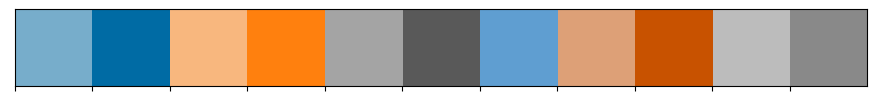

In [30]:
imp_order = full_set_df.sort_values(
    ["ctrl", "type", "group", "imputation"], ascending=[True, False, True, True]
)[["group", "imputation"]].drop_duplicates()
colors = imp_order["group"].unique()
n_colors = [len(imp_order[imp_order["group"] == c]) for c in colors]


def generate_color_palette(color_list):
    # Generate a base color palette
    base_palette = sns.color_palette(
        [
            "#006BA4",
            "#FF800E",
            "#595959",
            "#5F9ED1",
            "#C85200",
            "#898989",
            "#A2C8EC",
            "#FFBC79",
            "#CFCFCF",
        ],
        n_colors=len(color_list),
    )

    # Generate shades for each base color
    color_palette = []
    for i, color in enumerate(base_palette):
        shades = sns.light_palette(color, n_colors=color_list[i] + 1)
        color_palette.extend(shades[1:])

    return color_palette


# Generate the color palette
cset = generate_color_palette(n_colors)
sns.palplot(cset)
print(dict(zip(colors, n_colors)))

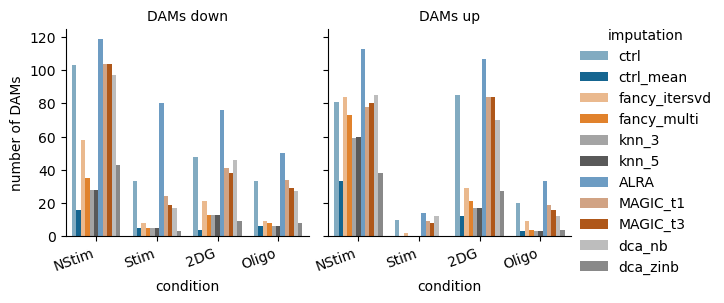

In [31]:
n_degs = (
    full_set_df.groupby(["imputation", "condition", "direction"])[["names"]]
    .count()
    .reset_index()
)

bar_n_degs = sns.catplot(
    data=n_degs,
    x="condition",
    order=cond_order,
    y="names",
    hue="imputation",
    hue_order=imp_order["imputation"],
    col="direction",
    palette=cset,
    kind="bar",
    sharey=True,
    sharex=True,
    height=3,
)

bar_n_degs.set_ylabels("number of DAMs")
bar_n_degs.set_xticklabels(rotation=20, ha="right")
bar_n_degs.set_titles("{col_name}", size=10)
bar_n_degs.savefig(os.path.join(write_path, f"{dataset}_n_degs.pdf"))

In [38]:
if sparse:
    ctrl = "baseline"
else:
    ctrl = "ctrl"

compare_df = pd.merge(
    n_degs,
    n_degs[n_degs["imputation"] == ctrl],
    on=["condition", "direction"],
    suffixes=["_imp", "_ctrl"],
)
compare_df["ratio"] = compare_df["names_imp"] / compare_df["names_ctrl"]
compare_df.groupby(["imputation_imp"])[["ratio"]].median().sort_values(
    "ratio", ascending=False
)

,ratio
imputation_imp,
ALRA,1.457576
ctrl,1.000000
MAGIC_t1,0.956481
dca_nb,0.882638
MAGIC_t3,0.839394
fancy_itersvd,0.389338
fancy_multi,0.247059
dca_zinb,0.242424
knn_3,0.200000


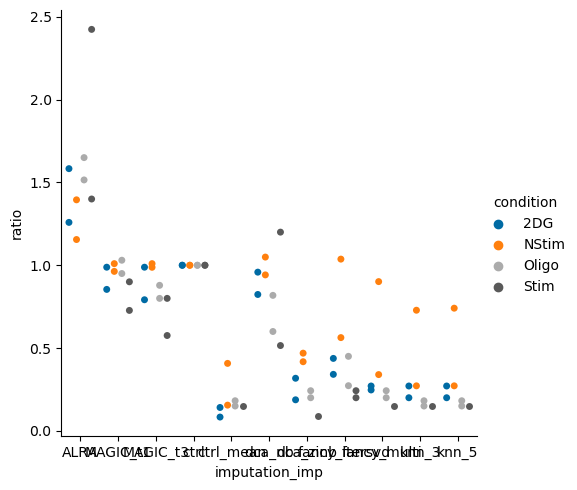

In [39]:
sns.catplot(
    data=compare_df,
    hue="condition",
    y="ratio",
    x="imputation_imp",
    dodge=True,
    jitter=False,
)

In [25]:
set_list = []
for layer in adata.layers.keys():
    adata_imp = adata
    sc.tl.rank_genes_groups(
        adata_imp,
        use_raw=False,
        groupby="condition",
        method="wilcoxon",
        key_added=f"wilcoxon_{layer}",
        layer=layer,
    )
    # sc.pl.rank_genes_groups(adata_magic, n_genes=25, sharey=False, key = "wilcoxon")
    for condition in adata_imp.obs["condition"].unique():
        df = sc.get.rank_genes_groups_df(
            adata_imp,
            group=condition,
            key=f"wilcoxon_{layer}",
            pval_cutoff=None,
            log2fc_min=0,
        )  # [['names']]
        df["imputation"] = layer
        df["condition"] = condition
        df["direction"] = "up"
        df["cond"] = condition + " up"
        set_list.append(df.sort_values(by="logfoldchanges", ascending=True))
        # set_list.append(df.sort_values(by='logfoldchanges', ascending=True).head(50))

        df = sc.get.rank_genes_groups_df(
            adata_imp,
            group=condition,
            key=f"wilcoxon_{layer}",
            pval_cutoff=None,
            log2fc_max=0,
        )  # [['names']]
        df["imputation"] = layer
        df["condition"] = condition
        df["direction"] = "down"
        df["cond"] = condition + " down"

        set_list.append(df.sort_values(by="logfoldchanges", ascending=False))
        # set_list.append(df.sort_values(by='logfoldchanges', ascending=False).head(50))

set_df = pd.concat(set_list, ignore_index=True)
set_df["group"] = list(set_df["imputation"].apply(lambda x: re.sub("_[^_]+$", "", x)))
set_df["ctrl"] = ["ctrl" if c == "ctrl" else "imputation" for c in set_df["group"]]

set_df = set_df[~set_df["imputation"].isin(exclude_imps)]
set_df["imputation"] = set_df["imputation"].astype("str")

In [26]:
set_df["lfc_rank"] = set_df.groupby(["imputation", "condition"])[
    ["logfoldchanges"]
].rank(ascending=False)
set_df

,names,scores,logfoldchanges,pvals,pvals_adj,imputation,condition,direction,cond,group,ctrl,lfc_rank
0,C22H29N3O13S+H,0.274363,0.005544,7.838058e-01,7.860325e-01,ALRA,MiaPaca2,up,MiaPaca2 up,ALRA,imputation,183.0
1,C24H52NO6P+H,-9.242145,0.011056,2.416056e-20,3.158770e-20,ALRA,MiaPaca2,up,MiaPaca2 up,ALRA,imputation,182.0
2,C35H68NO9P+Na,-5.348989,0.013563,8.844707e-08,1.027033e-07,ALRA,MiaPaca2,up,MiaPaca2 up,ALRA,imputation,181.0
3,C49H85O7P+Na,3.421514,0.027670,6.227362e-04,6.805755e-04,ALRA,MiaPaca2,up,MiaPaca2 up,ALRA,imputation,180.0
4,C43H76NO8P+H,1.272237,0.034134,2.032889e-01,2.086075e-01,ALRA,MiaPaca2,up,MiaPaca2 up,ALRA,imputation,179.0
...,...,...,...,...,...,...,...,...,...,...,...,...
36707,C51H89NO8+K,-17.254894,-0.474738,1.028106e-66,5.949533e-66,knn_5,PSN1,down,PSN1 down,knn,imputation,349.0
36708,C44H84NO8P+H,-19.618504,-0.477133,1.074697e-85,7.742202e-85,knn_5,PSN1,down,PSN1 down,knn,imputation,350.0
36709,C40H78NO8P+H,-20.657055,-0.501213,8.435565e-95,6.767624e-94,knn_5,PSN1,down,PSN1 down,knn,imputation,351.0
36710,C49H88NO10P+H,-18.418150,-0.505921,9.395920e-76,6.030472e-75,knn_5,PSN1,down,PSN1 down,knn,imputation,352.0


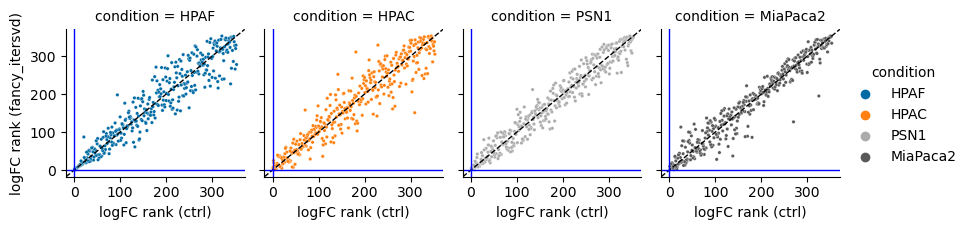

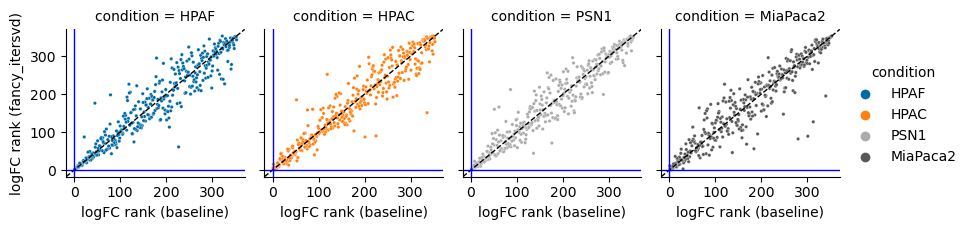

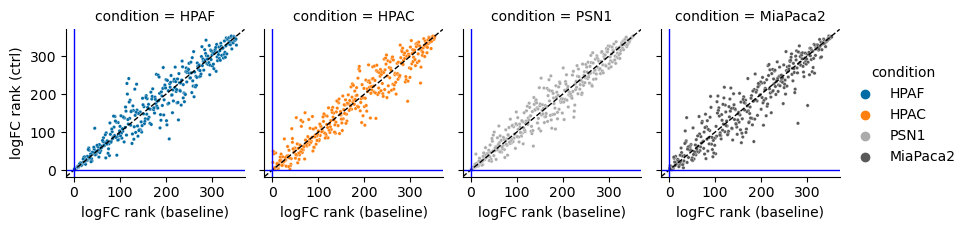

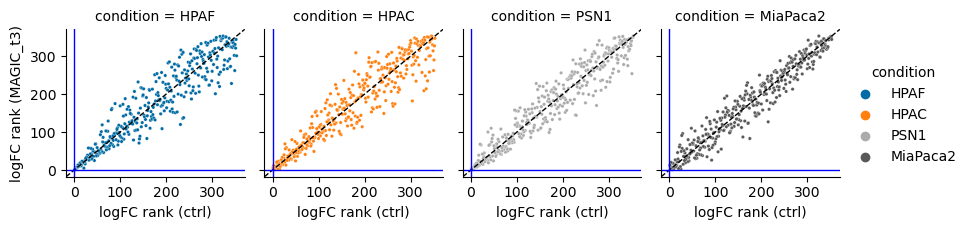

In [30]:
for combs in [
    ("ctrl", "fancy_itersvd"),
    ("baseline", "fancy_itersvd"),
    ("baseline", "ctrl"),
    ("ctrl", "MAGIC_t3"),
]:
    base_df = set_df[set_df["imputation"] == combs[0]]
    svd_df = set_df[set_df["imputation"] == combs[1]]
    m_df = pd.merge(base_df, svd_df, on=["names", "condition"], how="inner")
    if len(m_df) == 0:
        continue
    replot = sns.relplot(
        data=m_df,
        s=6,
        x="lfc_rank_x",
        y="lfc_rank_y",
        hue="condition",
        hue_order=cond_order,
        col_order=cond_order,
        col="condition",
        height=2.4,
        col_wrap=4,
        aspect=0.9,
        # bins=(20,20)
    )
    replot.set_xlabels(f"logFC rank ({combs[0]})")
    replot.set_ylabels(f"logFC rank ({combs[1]})")
    for ax in replot.axes.flatten():
        ax.axline((0, 0), slope=1, color="black", ls="--", lw=1)
        ax.axvline(0, color="blue", lw=1)
        ax.axhline(0, color="blue", lw=1)

    replot.savefig(
        os.path.join(write_path, f"{dataset}_log2fc_{combs[0]}_{combs[1]}.pdf")
    )

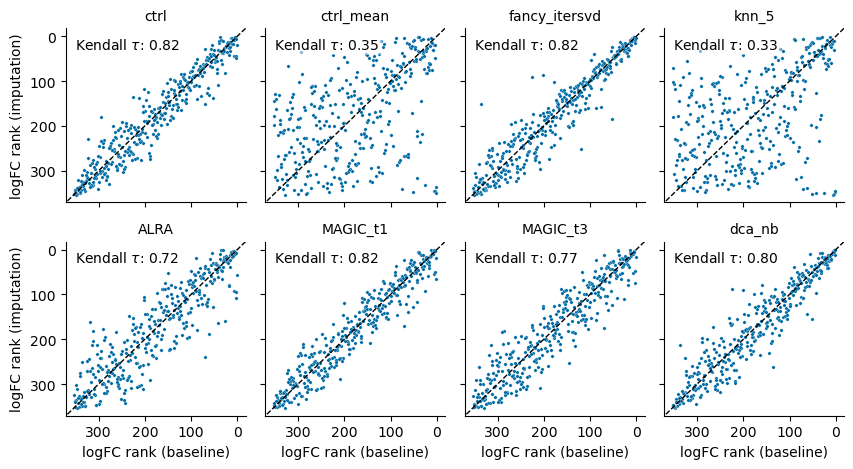

In [32]:
from scipy.stats import kendalltau

const.NARROW_BBOX.update(fc=(1, 1, 1, 0.5))

for combs in [("baseline", "HPAC")]:
    base_df = set_df[
        (set_df["imputation"] == combs[0]) & (set_df["condition"] == combs[1])
    ]
    svd_df = set_df[
        (set_df["imputation"] != combs[0]) & (set_df["condition"] == combs[1])
    ]
    m_df = pd.merge(base_df, svd_df, on=["names", "condition"], how="inner")
    if len(m_df) == 0:
        continue
    replot = sns.relplot(
        data=m_df,
        s=6,
        x="lfc_rank_x",
        y="lfc_rank_y",
        col_order=[
            "ctrl",
            "ctrl_mean",
            "fancy_itersvd",
            "knn_5",
            "ALRA",
            "MAGIC_t1",
            "MAGIC_t3",
            "dca_nb",
        ],
        col="imputation_y",
        height=2.4,
        col_wrap=4,
        aspect=0.9,
        # bins=(20,20)
    )
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    replot.set_titles("{col_name}")
    replot.set_xlabels(f"logFC rank ({combs[0]})")
    replot.set_ylabels(f"logFC rank (imputation)")
    # for ax in replot.axes.flatten():
    #     ax.axline((0, 0), slope=1, color='black', ls='--', lw=1)

    for (row, col, hue), data in replot.facet_data():
        ax = replot.facet_axis(row, col)
        ax.axline((0, 0), slope=1, color="black", ls="--", lw=1)
        kendall = list(kendalltau(data["logfoldchanges_x"], data["logfoldchanges_y"]))

        ax.text(
            0.05,
            0.95,
            r"Kendall $\tau$: " + f"{kendall[0]:.2f}",
            transform=ax.transAxes,
            ha="left",
            va="top",
            bbox=const.NARROW_BBOX,
        )
    replot.savefig(
        os.path.join(write_path, f"{dataset}_log2fc_{combs[0]}_{combs[1]}.pdf")
    )

In [33]:
write_path

'/home/mklein/Dropouts/figures'

In [41]:
from scipy.stats import kendalltau, spearmanr

overlap_list = []
compared_layers = set_df["imputation"].unique()
for cond in set_df["condition"].unique():
    incl_metab = full_set_df[
        (full_set_df["imputation"] == "baseline") & (full_set_df["condition"] == cond)
    ]["names"]
    metab_df = set_df[(set_df["condition"] == cond)]
    print(f"{cond} N metabolites: {len(incl_metab)}")
    for layer1 in compared_layers:
        for layer2 in compared_layers:
            r1 = metab_df[metab_df["imputation"] == layer1]
            r2 = metab_df[metab_df["imputation"] == layer2]
            r = pd.merge(r1, r2, on=["names"], suffixes=["_1", "_2"], how="inner")

            kendall = list(kendalltau(r["logfoldchanges_1"], r["logfoldchanges_2"]))
            spearman = spearmanr(r["logfoldchanges_1"], r["logfoldchanges_2"])
            # print(f"{cond} + {layer1} + {layer2} + {kendall[0]}")
            if kendall[1] > 0.05:
                kendall[0] = 0
            overlap_list.append(
                dict(
                    cond=cond,
                    direction="none",
                    condition=cond,
                    layer1=layer1,
                    layer2=layer2,
                    kendall=kendall[0],
                    kendall_P=kendall[1],
                    spearman=spearman[0],
                    spearman_P=spearman[1],
                )
            )

2DG N metabolites: 0
Oligo N metabolites: 0
Stim N metabolites: 0
NStim N metabolites: 0


In [52]:
set_list = []
for layer in adata.layers.keys():
    adata_imp = adata
    sc.tl.rank_genes_groups(
        adata_imp,
        use_raw=False,
        groupby="condition",
        method="wilcoxon",
        key_added=f"wilcoxon_{layer}",
        layer=layer,
    )
    # sc.pl.rank_genes_groups(adata_magic, n_genes=25, sharey=False, key = "wilcoxon")
    for condition in adata_imp.obs["condition"].unique():
        df = sc.get.rank_genes_groups_df(
            adata_imp,
            group=condition,
            key=f"wilcoxon_{layer}",
            pval_cutoff=None,
            log2fc_min=0,
        )  # [['names']]
        df["imputation"] = layer
        df["condition"] = condition
        df["direction"] = "up"
        df["cond"] = condition + " up"
        set_list.append(df.sort_values(by="logfoldchanges", ascending=True).head(20))

        df = sc.get.rank_genes_groups_df(
            adata_imp,
            group=condition,
            key=f"wilcoxon_{layer}",
            pval_cutoff=None,
            log2fc_max=0,
        )  # [['names']]
        df["imputation"] = layer
        df["condition"] = condition
        df["direction"] = "down"
        df["cond"] = condition + " down"
        set_list.append(df.sort_values(by="logfoldchanges", ascending=False).head(200))

set_df = pd.concat(set_list, ignore_index=True)
set_df["group"] = list(set_df["imputation"].apply(lambda x: re.sub("_[^_]+$", "", x)))
set_df["ctrl"] = ["ctrl" if c == "ctrl" else "imputation" for c in set_df["group"]]

set_df = set_df[~set_df["imputation"].isin(exclude_imps)]
set_df["imputation"] = set_df["imputation"].astype("str")

from sklearn.metrics import jaccard_score

overlap_list = []
compared_layers = set_df["imputation"].unique()
for cond in set_df["cond"].unique():
    for layer1 in compared_layers:
        for layer2 in compared_layers:
            set1 = set(
                set_df[(set_df["cond"] == cond) & (set_df["imputation"] == layer1)][
                    "names"
                ]
            )
            set2 = set(
                set_df[(set_df["cond"] == cond) & (set_df["imputation"] == layer2)][
                    "names"
                ]
            )
            array1 = np.array([1 if x in set1 else 0 for x in set(set1.union(set2))])
            array2 = np.array([1 if x in set2 else 0 for x in set(set1.union(set2))])

            # print(f"{cond} + {layer1} + {set1}")
            # print(f"{cond} + {layer2} + {set2}")
            # print(jaccard_score(array1, array2))
            overlap_list.append(
                dict(
                    cond=cond,
                    direction=set_df[(set_df["cond"] == cond)]["direction"].iloc[0],
                    condition=set_df[(set_df["cond"] == cond)]["condition"].iloc[0],
                    layer1=layer1,
                    layer2=layer2,
                    jaccard=jaccard_score(array1, array2),
                )
            )

In [53]:
overlap_df = pd.DataFrame(overlap_list)
overlap_df["cond2"] = overlap_df["cond"]
overlap_df["imputation 1"] = overlap_df["layer1"]
overlap_df["imputation 2"] = overlap_df["layer2"]

if "jaccard" in overlap_df.columns:
    column = "jaccard"
    title_text = "Jaccard similarity of differential\nmetabolites"
else:
    column = "kendall"
    title_text = "Kendall tau of metabolite \nlog-fold changes"
    # column = 'spearman'
    # title_text = 'Spearman of metabolite \nlog-fold changes'

overlap_df  # [overlap_df['jaccard'] < 1.0]

,cond,direction,condition,layer1,layer2,jaccard,cond2,imputation 1,imputation 2
0,2DG up,up,2DG,ALRA,ALRA,1.000000,2DG up,ALRA,ALRA
1,2DG up,up,2DG,ALRA,MAGIC_t1,0.142857,2DG up,ALRA,MAGIC_t1
2,2DG up,up,2DG,ALRA,MAGIC_t3,0.290323,2DG up,ALRA,MAGIC_t3
3,2DG up,up,2DG,ALRA,baseline,0.025641,2DG up,ALRA,baseline
4,2DG up,up,2DG,ALRA,ctrl,0.052632,2DG up,ALRA,ctrl
...,...,...,...,...,...,...,...,...,...
1147,NStim down,down,NStim,knn_5,dca_zinb,0.511905,NStim down,knn_5,dca_zinb
1148,NStim down,down,NStim,knn_5,fancy_itersvd,0.600000,NStim down,knn_5,fancy_itersvd
1149,NStim down,down,NStim,knn_5,fancy_multi,0.623288,NStim down,knn_5,fancy_multi
1150,NStim down,down,NStim,knn_5,knn_3,0.935780,NStim down,knn_5,knn_3


In [583]:
out_df = overlap_df.reset_index()
out_df["dataset"] = dataset_set
out_df["sparse"] = sparse
out_df["dr"] = adata.uns["dropout_rate"]
out_df.to_csv(os.path.join(write_path, f"{dataset}_{column}_ovlps.csv"))

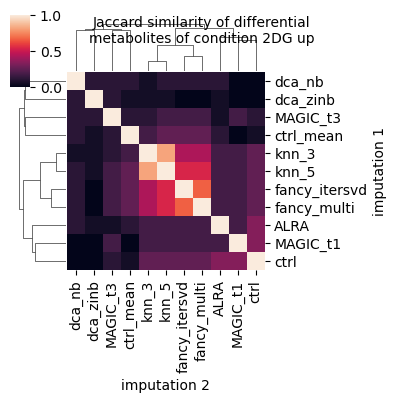

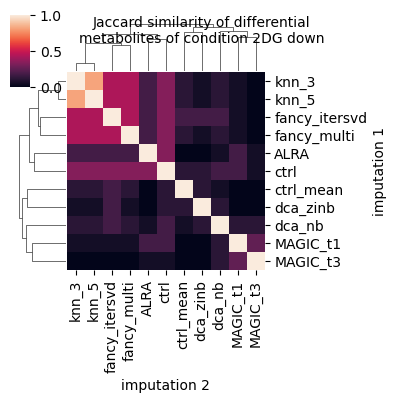

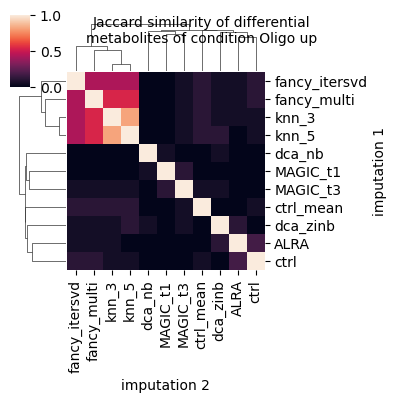

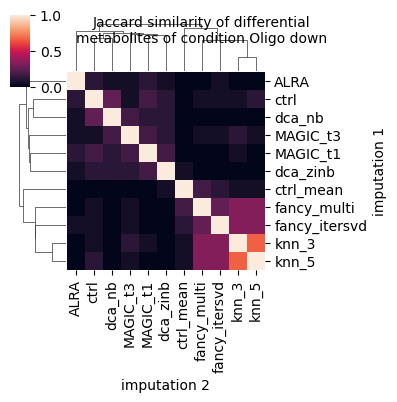

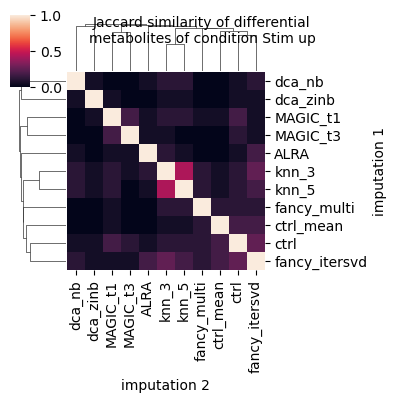

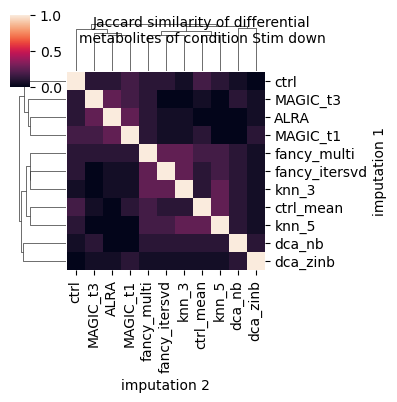

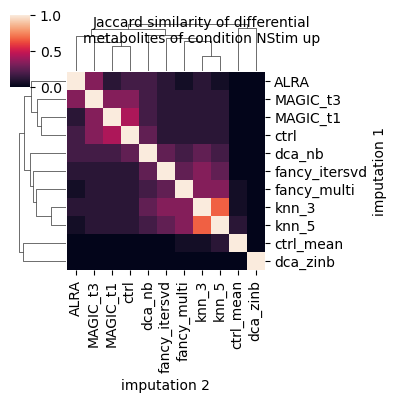

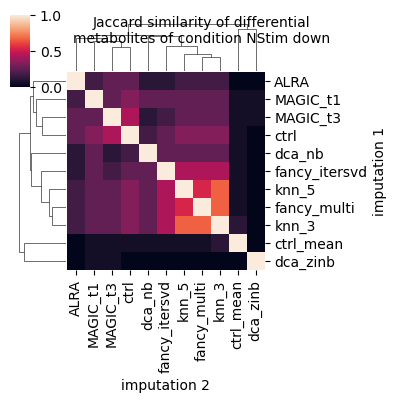

In [44]:
for condition in overlap_df.cond.unique():
    deg_ovl_plot = sns.clustermap(
        overlap_df[overlap_df["cond"] == condition]
        .pivot(index=["imputation 1"], columns=["imputation 2"], values=column)
        .replace(np.nan, 0),
        vmin=0,
        vmax=1,
        figsize=(4, 4),
    )
    deg_ovl_plot.fig.suptitle(f"{title_text} of condition {condition}", size=10)

In [ ]:
# if column == 'jaccard':
#     updown_df = overlap_df.groupby(['imputation 1', 'imputation 2', 'direction']).mean().reset_index().pivot(index=['direction', 'imputation 1'], columns=['imputation 2'], values='kendall').replace(np.nan, 0)
#     deg_ovl_plot = sns.clustermap(
#         updown_df[updown_df.index.get_level_values('direction') == 'up'].reset_index('direction', drop=True),
#         vmin=0,
#         vmax=1,
#         figsize=(size, size))
#     deg_ovl_plot.fig.suptitle(f"Jaccard similarity of differential\nmetabolites (up, mean)", size=10)
#     deg_ovl_plot.savefig(os.path.join(write_path, f'{dataset}_deg_ovl_up.pdf'))

#     deg_ovl_plot = sns.clustermap(
#         updown_df[updown_df.index.get_level_values('direction') == 'down'].reset_index('direction', drop=True),
#         vmin=0,
#         vmax=1,
#         figsize=(size, size))
#     deg_ovl_plot.fig.suptitle(f"Jaccard similarity of differential\nmetabolites (down, mean)", size=10)
#     deg_ovl_plot.savefig(os.path.join(write_path, f'{dataset}_deg_ovl_down.pdf'))
#     overlap_df

/tmp/ipykernel_75/1464640033.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  overlap_df.groupby(['imputation 1', 'imputation 2']).mean().reset_index().pivot(index=['imputation 1'], columns=['imputation 2'], values=column).replace(np.nan, 0),


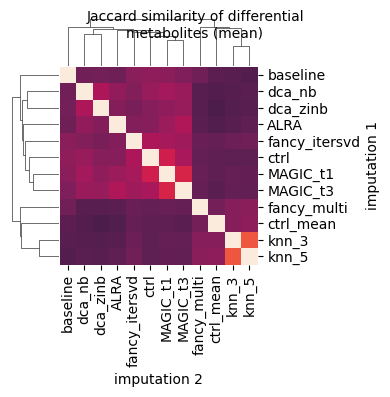

In [54]:
deg_ovl_plot = sns.clustermap(
    overlap_df.groupby(["imputation 1", "imputation 2"])
    .mean()
    .reset_index()
    .pivot(index=["imputation 1"], columns=["imputation 2"], values=column)
    .replace(np.nan, 0),
    vmin=0,
    vmax=1,
    figsize=(size, size),
    cbar_pos=None,
)
deg_ovl_plot.fig.suptitle(f"{title_text} (mean)", size=10)
deg_ovl_plot.savefig(os.path.join(write_path, f"{dataset}_{column}_deg_ovl_mean.pdf"))

/tmp/ipykernel_620/3028864052.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  overlap_df.groupby(['imputation 1', 'imputation 2']).mean().reset_index().pivot(index=['imputation 1'], columns=['imputation 2'], values=column).replace(np.nan, 0),


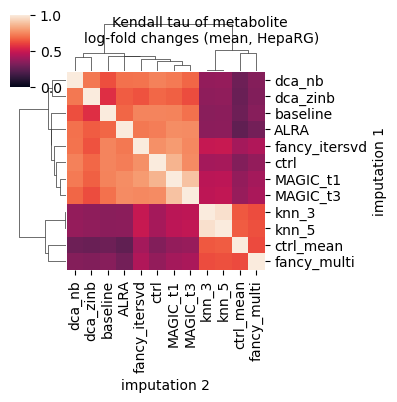

In [573]:
deg_ovl_plot = sns.clustermap(
    overlap_df.groupby(["imputation 1", "imputation 2"])
    .mean()
    .reset_index()
    .pivot(index=["imputation 1"], columns=["imputation 2"], values=column)
    .replace(np.nan, 0),
    vmin=0,
    vmax=1,
    figsize=(size, size),
)
deg_ovl_plot.fig.suptitle(f"{title_text} (mean, {dataset_disp})", size=10)
deg_ovl_plot.savefig(
    os.path.join(write_path, f"{dataset}_{column}_cbar_deg_ovl_mean.pdf")
)

In [564]:
hvg_set_list = []
for layer in compared_layers:
    adata_imp = adata.copy()
    sc.pp.highly_variable_genes(
        adata, layer=layer, n_top_genes=None, flavor="cell_ranger"
    )
    df = adata.var[adata.var["highly_variable"]][["annotation_id"]]
    df["imputation"] = layer
    df["condition"] = condition
    hvg_set_list.append(df.reset_index())
    print(layer, len(df))

hvg_set_df = pd.concat(hvg_set_list)
hvg_set_df["condition"] = "whole dataset"
hvg_set_df["direction"] = "HVMs"
hvg_set_df["names"] = hvg_set_df["index"]

hvg_set_df = hvg_set_df[~hvg_set_df["imputation"].isin(exclude_imps)]
hvg_set_df

ALRA 85
MAGIC_t1 91
MAGIC_t3 99
baseline 88
ctrl 95
ctrl_mean 35
dca_nb 70
dca_zinb 52
fancy_itersvd 76
fancy_multi 37
knn_3 53
knn_5 55


,index,annotation_id,imputation,condition,direction,names
0,C10H21NO4+K,C10H21NO4+K,ALRA,whole dataset,HVMs,C10H21NO4+K
1,C13H17NO3+Na,C13H17NO3+Na,ALRA,whole dataset,HVMs,C13H17NO3+Na
2,C14H17NO4+K,C14H17NO4+K,ALRA,whole dataset,HVMs,C14H17NO4+K
3,C14H19NO5+K,C14H19NO5+K,ALRA,whole dataset,HVMs,C14H19NO5+K
4,C15H23N3O3+H,C15H23N3O3+H,ALRA,whole dataset,HVMs,C15H23N3O3+H
...,...,...,...,...,...,...
50,C47H81O13P+Na,C47H81O13P+Na,knn_5,whole dataset,HVMs,C47H81O13P+Na
51,C47H83O13P+Na,C47H83O13P+Na,knn_5,whole dataset,HVMs,C47H83O13P+Na
52,C48H83NO8+K,C48H83NO8+K,knn_5,whole dataset,HVMs,C48H83NO8+K
53,C48H93O8P+K,C48H93O8P+K,knn_5,whole dataset,HVMs,C48H93O8P+K


In [565]:
n_degs = (
    set_df.groupby(["imputation", "condition", "direction"])[["names"]]
    .count()
    .reset_index()
)
n_degs.condition = n_degs.condition.astype("category")
n_degs.condition

0       F
1       F
2      FI
3      FI
4     FIT
     ... 
91     FI
92    FIT
93    FIT
94      U
95      U
Name: condition, Length: 96, dtype: category
Categories (4, object): ['F', 'FI', 'FIT', 'U']

'/home/mklein/Dropouts/figures/n_hvms.pdf'

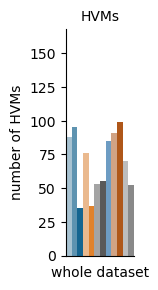

In [566]:
hvg_n_degs = hvg_set_df.groupby(["imputation"])[["index"]].count().reset_index()

hvg_bar_n_degs = sns.catplot(
    data=hvg_n_degs,
    x="imputation",
    y="index",
    order=imp_order["imputation"],
    palette=cset,
    width=1,
    kind="bar",
    sharey=False,
    sharex=False,
    aspect=0.6,
    height=3,
)

hvg_bar_n_degs.set_ylabels("number of HVMs")
hvg_bar_n_degs.set_xlabels("whole dataset")
hvg_bar_n_degs.set_xticklabels([])


hvg_bar_n_degs.axes.flat[0].set_title("HVMs", size=10)
hvg_bar_n_degs.axes.flat[0].set_xticks([])
hvg_bar_n_degs.axes.flat[0].set_ylim(0, bar_n_degs.axes.flat[0].get_ylim()[1])
hvg_bar_n_degs.savefig(os.path.join(write_path, f"{dataset}_n_hvms.pdf"))
os.path.join(write_path, "n_hvms.pdf")

In [567]:
hvg_overlap_list = []
for layer1 in compared_layers:
    for layer2 in compared_layers:
        set1 = set(hvg_set_df[(hvg_set_df["imputation"] == layer1)]["index"])
        set2 = set(hvg_set_df[(hvg_set_df["imputation"] == layer2)]["index"])
        array1 = np.array([1 if x in set1 else 0 for x in set(set1.union(set2))])
        array2 = np.array([1 if x in set2 else 0 for x in set(set1.union(set2))])

        # print(f"{cond} + {layer1} + {set1}")
        # print(f"{cond} + {layer2} + {set2}")
        # print(jaccard_score(array1, array2))
        hvg_overlap_list.append(
            dict(layer1=layer1, layer2=layer2, jaccard=jaccard_score(array1, array2))
        )

hvg_overlap_df = pd.DataFrame(hvg_overlap_list)
hvg_overlap_df["imputation 1"] = hvg_overlap_df["layer1"]
hvg_overlap_df["imputation 2"] = hvg_overlap_df["layer2"]
hvg_overlap_df

,layer1,layer2,jaccard,imputation 1,imputation 2
0,ALRA,ALRA,1.000000,ALRA,ALRA
1,ALRA,MAGIC_t1,0.478992,ALRA,MAGIC_t1
2,ALRA,MAGIC_t3,0.508197,ALRA,MAGIC_t3
3,ALRA,baseline,0.291045,ALRA,baseline
4,ALRA,ctrl,0.525424,ALRA,ctrl
...,...,...,...,...,...
139,knn_5,dca_zinb,0.150538,knn_5,dca_zinb
140,knn_5,fancy_itersvd,0.190909,knn_5,fancy_itersvd
141,knn_5,fancy_multi,0.108434,knn_5,fancy_multi
142,knn_5,knn_3,0.714286,knn_5,knn_3


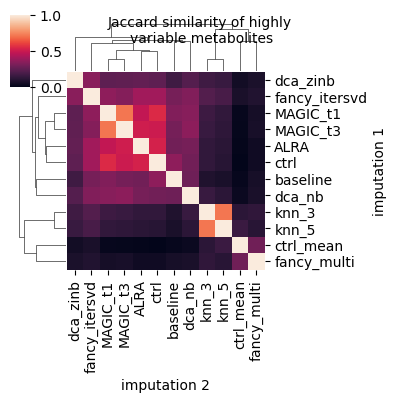

In [568]:
hvg_plot = sns.clustermap(
    hvg_overlap_df.reset_index()
    .pivot(index=["imputation 1"], columns=["imputation 2"], values="jaccard")
    .replace(np.nan, 0),
    vmin=0,
    vmax=1,
    figsize=(size, size),
    # cmap='cividis'
)
hvg_plot.fig.suptitle(f"Jaccard similarity of highly \nvariable metabolites", size=10)
hvg_plot.savefig(os.path.join(write_path, f"{dataset}_hvg_overlap.pdf"))

In [569]:
hvg_overlap_df.reset_index().pivot(
    index=["imputation 1"], columns=["imputation 2"], values="jaccard"
).replace(np.nan, 0)

imputation 2,ALRA,MAGIC_t1,MAGIC_t3,baseline,ctrl,ctrl_mean,dca_nb,dca_zinb,fancy_itersvd,fancy_multi,knn_3,knn_5
imputation 1,,,,,,,,,,,,
ALRA,1.000000,0.478992,0.508197,0.291045,0.525424,0.008403,0.302521,0.256881,0.400000,0.042735,0.131148,0.111111
MAGIC_t1,0.478992,1.000000,0.711712,0.325926,0.550000,0.016129,0.341667,0.243478,0.357724,0.057851,0.161290,0.131783
MAGIC_t3,0.508197,0.711712,1.000000,0.298611,0.503876,0.015152,0.352000,0.247934,0.335878,0.062500,0.151515,0.124088
baseline,0.291045,0.325926,0.298611,1.000000,0.355556,0.016529,0.284553,0.166667,0.301587,0.059322,0.084615,0.067164
ctrl,0.525424,0.550000,0.503876,0.355556,1.000000,0.000000,0.289062,0.245763,0.401639,0.039370,0.129771,0.102941
ctrl_mean,0.008403,0.016129,0.015152,0.016529,0.000000,1.000000,0.029412,0.048193,0.067308,0.285714,0.113924,0.153846
dca_nb,0.302521,0.341667,0.352000,0.284553,0.289062,0.029412,1.000000,0.220000,0.327273,0.070000,0.149533,0.116071
dca_zinb,0.256881,0.243478,0.247934,0.166667,0.245763,0.048193,0.220000,1.000000,0.347368,0.072289,0.166667,0.150538
fancy_itersvd,0.400000,0.357724,0.335878,0.301587,0.401639,0.067308,0.327273,0.347368,1.000000,0.086538,0.216981,0.190909


In [584]:
i = 3
sparse = True

HepaRG


Layers with keys: ALRA, MAGIC_t1, MAGIC_t2, MAGIC_t3, MAGIC_t5, baseline, ctrl, ctrl_mean, ctrl_median, ctrl_random, dca_nb, dca_nb-conddisp, dca_zinb, dca_zinb-conddisp, fancy_iterative, fancy_itersvd, fancy_multi, fancy_soft, fancy_softbi, knn_1, knn_3, knn_5

In [610]:
dataset_df

,dataset,replicate,adata_path,sp_adata_path,min_ions,min_cells,save_to,max_fdr
0,Mx_Seahorse,Mx_Seahorse_cond4_mnar_c0.1_i0.2_fdr1_repl1,/g/alexandr/Marius/imputation_evaluation/Mx_Se...,/g/alexandr/Marius/imputation_evaluation/Mx_Se...,0.20,0.10,/g/alexandr/Marius/imputation_evaluation/Mx_Se...,1
1,Lx_Pancreatic_Cancer,Lx_Pancreatic_Cancer_cond4_mnar_c0.2_i0.05_fdr...,/g/alexandr/Marius/imputation_evaluation/Lx_Pa...,/g/alexandr/Marius/imputation_evaluation/Lx_Pa...,0.05,0.20,/g/alexandr/Marius/imputation_evaluation/Lx_Pa...,1
2,Lx_Glioblastoma,Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4,/g/alexandr/Marius/imputation_evaluation/Lx_Gl...,/g/alexandr/Marius/imputation_evaluation/Lx_Gl...,0.05,0.05,/g/alexandr/Marius/imputation_evaluation/Lx_Gl...,1
3,Lx_HepaRG,Lx_HepaRG_cond4_mnar_c0.2_i0.2_fdr1_repl5,/g/alexandr/Marius/imputation_evaluation/Lx_He...,/g/alexandr/Marius/imputation_evaluation/Lx_He...,0.20,0.20,/g/alexandr/Marius/imputation_evaluation/Lx_He...,1
